Mobility data saved as 'mobility_data.csv'


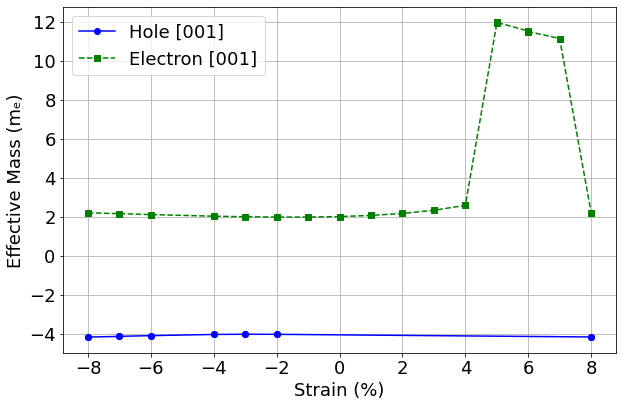

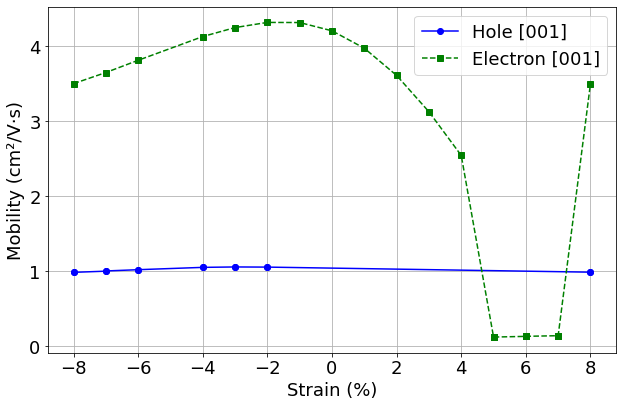

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# 1. Load Effective Mass Data
# ============================
effmass_df = pd.read_csv('Effective_mass_data.csv')

# Clean 'Direction' format (e.g., '[0. 0. 1.]' -> '0 0 1')
effmass_df['Direction'] = (
    effmass_df['Direction'].astype(str)
    .str.replace(r"[\[\]\.]", "", regex=True)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
)

# Normalize directions: treat '-0 -0 1' as '0 0 1'
effmass_df['Direction'] = effmass_df['Direction'].replace({'-0 -0 1': '0 0 1'})

# Drop missing or invalid effective mass data
effmass_df = effmass_df.dropna(subset=['Least squares', 'Strain'])
effmass_df['Least squares'] = pd.to_numeric(effmass_df['Least squares'], errors='coerce')
effmass_df = effmass_df.dropna(subset=['Least squares'])

# ============================
# 2. Calculate Mobility
# ============================
# Constants
e_charge = 1.602176634e-19  # C
hbar = 1.054571817e-34      # J·s
m0 = 9.10938356e-31         # kg
kB = 1.380649e-23           # J/K
T = 300                     # K
C = 30                   # N/m
E_def_eV = 5.0              # eV
E_def = E_def_eV * e_charge # J

# Compute effective mass in SI units and mobility in cm²/V·s
effmass_df['EffMass_SI'] = effmass_df['Least squares'] * m0
effmass_df['Mobility (cm²/V·s)'] = (
    (2 * e_charge * hbar**3 * C) /
    (3 * kB * T * effmass_df['EffMass_SI']**2 * E_def**2)
) * 1e4  # Convert to cm²/V·s

# Save processed data
effmass_df.to_csv('mobility_data.csv', index=False)
print("Mobility data saved as 'mobility_data.csv'")

# ============================
# 3. Filter for c-direction
# ============================
c_data = effmass_df[effmass_df['Direction'] == '0 0 1']

# ============================
# 4. Helper Function
# ============================
def get_sorted(data, particle, direction, column):
    subset = data[(data['Particle'] == particle) & (data['Direction'] == direction)]
    strain = subset['Strain'].astype(str).str.replace('%', '').astype(float)
    values = subset[column]
    sorted_indices = np.argsort(strain)
    return strain.iloc[sorted_indices], values.iloc[sorted_indices]

# Apply font size globally
plt.rcParams.update({'font.size': 18})

# ============================
# 5. Plot Effective Mass
# ============================
plt.figure(figsize=(9, 6))
for particle, linestyle, color, marker in zip(
    ['hole', 'electron'], ['-', '--'], ['blue', 'green'], ['o', 's']
):
    strain, effmass = get_sorted(c_data, particle, '0 0 1', 'Least squares')
    if not strain.empty:
        plt.plot(strain, effmass, label=f"{particle.capitalize()} [001]",
                 marker=marker, linestyle=linestyle, color=color)

plt.xlabel('Strain (%)')
plt.ylabel('Effective Mass (mₑ)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('C_Effmass.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================
# 6. Plot Mobility
# ============================
plt.figure(figsize=(9, 6))
for particle, linestyle, color, marker in zip(
    ['hole', 'electron'], ['-', '--'], ['blue', 'green'], ['o', 's']
):
    strain, mobility = get_sorted(c_data, particle, '0 0 1', 'Mobility (cm²/V·s)')
    if not strain.empty:
        plt.plot(strain, mobility, label=f"{particle.capitalize()} [001]",
                 marker=marker, linestyle=linestyle, color=color)

plt.xlabel('Strain (%)')
plt.ylabel('Mobility (cm²/V·s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('C_Mobility.png', dpi=300, bbox_inches='tight')
plt.show()
